## This project is an attempt to create a simple Neural Network model that will be able to separate fake from real news

In [2]:
#import torch and torchtext libraries to pre-process dataset
import torch
from torch import nn
try:
  import torchtext
except:
  !pip install torchtext
  print("installing tochtext...")
  import torchtext

#creat device-agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"

device


'cpu'

## Understanding our data

The dataset we will be using is a custom csv file containing news articles and a label which classifies them as true (label=0) or false (label=1). We will start experimenting on a small scale dataset and expand afterwards when necessary.

In [3]:
#import dataset from github
#get the file containing the subset
import requests
import zipfile
from pathlib import Path

data_path=Path("/data")

fake_news_path=data_path / "fake_news_dataset"

#if the folder does not exist download it and prepare it
if fake_news_path.is_dir():
  print(f"{fake_news_path} directory already exists")
else:
  print(f"{fake_news_path} does not exist, creating directory...")
  fake_news_path.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, sushi data
with open(data_path / "data.zip", "wb") as f:
    request = requests.get("https://github.com/AntonisGantzos/Pytorch_Fake_News_detection/raw/main/data.zip")
    print("Downloading fake news data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
    print("Unzipping fake news data...")
    zip_ref.extractall(fake_news_path)

/data/fake_news_dataset directory already exists
Unzipping fake news data...


In [4]:
#use pandas to make our dataset into a dataframe
import pandas as pd
import io
df=pd.read_csv(fake_news_path/"train_small_scale.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
#get additional info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10800 non-null  int64 
 1   title   10505 non-null  object
 2   author  9774 non-null   object
 3   text    10778 non-null  object
 4   label   10800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 422.0+ KB


## Useful info about our data

It appears that our dataset is comprised of 5 features an id feature (useless when it comes to training our model), a title and text feature, that contain the title and main text of the article respectively and lastly an author feature crediting the author responsible for the creation of the article.  

In [6]:
#it is also really important to get an idea of the general shape of our dataset
df.shape

(10800, 5)

## Pre-Processing the data
Now we have imported our dataset we can start "cleaning up" our data so that it is of better use, when we start feeding it to our model. FIrstly, some key actrions we have to take :

* Remove missing values
* Remove duplicate data entries
* Lower casing all data entries
* Remove punctuation from all data entries
We perform actions 3 and 4 so that for example the word "Hello!" is treated the same way and has the same numerical value as the word "HELLO" and the word "hello."
* Remove all stopwords since they dont provide valuable information in analysing the text
* Remove rare/frequent words for the same reason as action 5
* Stemming
* Remove all URLs/emojis or emoitcons from the text since they dont provide any info or have any value in our dataset
* Spelling correction  

In [7]:
#drop duplicates and check the shape of our data again

df.drop_duplicates(inplace=True)
print(f"the shape of our data when duplicates are removed is {df.shape}")

#we also need to get a basic idea of the number of real and fake values in our dataset
df.label.value_counts()

the shape of our data when duplicates are removed is (10800, 5)


1    5417
0    5383
Name: label, dtype: int64

In [8]:
#now to check for missing values in each column
print(f"total missing values in our dataset are : {df.isnull().sum()}")

#remove all missing values and check the shape
df.dropna(axis=0, inplace=True)
print(f"the shape of our data after removing all null/missing values is {df.shape}")

total missing values in our dataset are : id           0
title      295
author    1026
text        22
label        0
dtype: int64
the shape of our data after removing all null/missing values is (9479, 5)


In [9]:
#lower casing all columns
df['title']=df["title"].str.lower()
df['author']=df['author'].str.lower()
df['text']=df['text'].str.lower()
df.head()

,id,title,author,text,label
0,0,house dem aide: we didn’t even see comey’s let...,darrell lucus,house dem aide: we didn’t even see comey’s let...,1
1,1,"flynn: hillary clinton, big woman on campus - ...",daniel j. flynn,ever get the feeling your life circles the rou...,0
2,2,why the truth might get you fired,consortiumnews.com,"why the truth might get you fired october 29, ...",1
3,3,15 civilians killed in single us airstrike hav...,jessica purkiss,videos 15 civilians killed in single us airstr...,1
4,4,iranian woman jailed for fictional unpublished...,howard portnoy,print \nan iranian woman has been sentenced to...,1


In [10]:
#remove punctuation
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df["title"] = df["title"].apply(lambda text: remove_punctuation(text))
df["author"] = df["author"].apply(lambda text: remove_punctuation(text))

df.head()

,id,title,author,text,label
0,0,house dem aide we didn’t even see comey’s lett...,darrell lucus,house dem aide we didn’t even see comey’s lett...,1
1,1,flynn hillary clinton big woman on campus bre...,daniel j flynn,ever get the feeling your life circles the rou...,0
2,2,why the truth might get you fired,consortiumnewscom,why the truth might get you fired october 29 2...,1
3,3,15 civilians killed in single us airstrike hav...,jessica purkiss,videos 15 civilians killed in single us airstr...,1
4,4,iranian woman jailed for fictional unpublished...,howard portnoy,print \nan iranian woman has been sentenced to...,1


In [11]:
#view all stopwords that we need to remove
from nltk.corpus import stopwords
import nltk

try:
  nltk.download('stopwords')
except:
  print("error in downloading stopwords")

", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [12]:
#use a function to remove all stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head()

,id,title,author,text,label
0,0,house dem aide we didn’t even see comey’s lett...,darrell lucus,house dem aide didn’t even see comey’s letter ...,1
1,1,flynn hillary clinton big woman on campus bre...,daniel j flynn,ever get feeling life circles roundabout rathe...,0
2,2,why the truth might get you fired,consortiumnewscom,truth might get fired october 29 2016 tension ...,1
3,3,15 civilians killed in single us airstrike hav...,jessica purkiss,videos 15 civilians killed single us airstrike...,1
4,4,iranian woman jailed for fictional unpublished...,howard portnoy,print iranian woman sentenced six years prison...,1


In [13]:
#remove all frequent/rare words only from text and title since author column onlu contains names
#first we have to find which are the most frequent words
#from collections import Counter
#from tqdm.auto import tqdm

#def remove_freqwords(text, FREQWORDS):
#    """custom function to remove the frequent words"""
#    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#def find_and_remove_freq_words(df):
#  cnt = Counter()
#  for text in df.values:
#      for word in text.split():
#          cnt[word] += 1

  #print(f"most frequent words are {cnt.most_common(10)}")

#  df = df.apply(lambda text: remove_freqwords(text, set([w for (w, wc) in cnt.most_common(3)])))


#find_and_remove_freq_words(df['text'])
#df.head()


In [14]:
#stemming
from nltk.stem.porter import PorterStemmer
from tqdm.auto import tqdm

stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["text"] = df["text"].apply(lambda text: stem_words(text))
df["title"] = df["title"].apply(lambda text: stem_words(text))

df.head()

,id,title,author,text,label
0,0,hous dem aid we didn’t even see comey’ letter ...,darrell lucus,hous dem aid didn’t even see comey’ letter jas...,1
1,1,flynn hillari clinton big woman on campu breit...,daniel j flynn,ever get feel life circl roundabout rather hea...,0
2,2,whi the truth might get you fire,consortiumnewscom,truth might get fire octob 29 2016 tension int...,1
3,3,15 civilian kill in singl us airstrik have bee...,jessica purkiss,video 15 civilian kill singl us airstrik ident...,1
4,4,iranian woman jail for fiction unpublish stori...,howard portnoy,print iranian woman sentenc six year prison ir...,1


In [15]:
#remove emojis and emoticons
import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df["text"] = df["text"].apply(lambda text: remove_emoji(text))
df["title"] = df["title"].apply(lambda text: remove_emoji(text))

df.head()

,id,title,author,text,label
0,0,hous dem aid we didn’t even see comey’ letter ...,darrell lucus,hous dem aid didn’t even see comey’ letter jas...,1
1,1,flynn hillari clinton big woman on campu breit...,daniel j flynn,ever get feel life circl roundabout rather hea...,0
2,2,whi the truth might get you fire,consortiumnewscom,truth might get fire octob 29 2016 tension int...,1
3,3,15 civilian kill in singl us airstrik have bee...,jessica purkiss,video 15 civilian kill singl us airstrik ident...,1
4,4,iranian woman jail for fiction unpublish stori...,howard portnoy,print iranian woman sentenc six year prison ir...,1


In [16]:
#remove all urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df["text"] = df["text"].apply(lambda text: remove_emoji(text))
df["title"] = df["title"].apply(lambda text: remove_urls(text))

df.head()

,id,title,author,text,label
0,0,hous dem aid we didn’t even see comey’ letter ...,darrell lucus,hous dem aid didn’t even see comey’ letter jas...,1
1,1,flynn hillari clinton big woman on campu breit...,daniel j flynn,ever get feel life circl roundabout rather hea...,0
2,2,whi the truth might get you fire,consortiumnewscom,truth might get fire octob 29 2016 tension int...,1
3,3,15 civilian kill in singl us airstrik have bee...,jessica purkiss,video 15 civilian kill singl us airstrik ident...,1
4,4,iranian woman jail for fiction unpublish stori...,howard portnoy,print iranian woman sentenc six year prison ir...,1


In [17]:
#spelling correction
#try:
#  import spellchecker
#except:
#  !pip install pyspellchecker



#from spellchecker import SpellChecker

#spell = SpellChecker()

#def correct_spellings(text):
#    words = text.split()
#    corrected_text = []
#    for word in words:
#        corrected_word = spell.correction(word)
#        if corrected_word:
#            corrected_text.append(corrected_word)
#        else:
#            corrected_text.append(word)  # Keep the original word if no correction is found
#   return " ".join(corrected_text)

#df["text"] = df["text"].apply(lambda text: correct_spellings(text))
#df.head()


In [18]:
#next we combine all our columns into one

for col in df.columns:
  print(f"dataframe column : {col}")


if 'title' in df.columns:
  df['text']=df['title'] + ' ' + df['text'] + ' ' + df['author']
  df.drop(columns=['id', 'title', 'author'], axis=1, inplace=True)
else:
  print("the columns have already been removed all relative data has been added to column text")

df.head()

dataframe column : id
dataframe column : title
dataframe column : author
dataframe column : text
dataframe column : label


,text,label
0,hous dem aid we didn’t even see comey’ letter ...,1
1,flynn hillari clinton big woman on campu breit...,0
2,whi the truth might get you fire truth might g...,1
3,15 civilian kill in singl us airstrik have bee...,1
4,iranian woman jail for fiction unpublish stori...,1


In [19]:
#try:
#  import nltk
#  nltk.download('punkt')
#except:
#  !pip install nltk

#map text term to index and make a vocabulary. the index is what will be later on converted to tensor
#def get_vocab(training_corpus):

    # add special characters
    # padding, end of line, unknown term
#    vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}

    # build vocab from training corpus
#    for item in training_corpus:
#        token=nltk.word_tokenize(item)
 #       for word in token: # for each word in tokens
#         if word not in vocab: # if word not in vocab
#              vocab[word] = len(vocab) # create an entry in the vocab equal to the term, and its value is the length of the vocab
#    return vocab

#vocab = get_vocab(item for item in df['text'])


In [20]:
#from collections import Counter
#ef text_to_tensor(text, vocab_dict: dict, unk_token='__UNK__', verbose=False):

    #Arguments:
    #    text - string containing the text
    #   vocab_dict - term vocabulary
    #   unk_token - special char used to map the unknown items
    #    verbose - print debug messages
    #Returns:
    #    tensor_l - a tensor containing the indices of our terms

#    word_l = nltk.word_tokenize(text)
#    if verbose:
#        print("List of words in our text:")
#        print(word_l)

    # take the __UNK__ value fro mthe vocabulary
#    unk_ID = vocab_dict[unk_token]

#    if verbose:
#        print(f"UNK has a value of {unk_ID}")

    # for each word in the lsit:
#    for word in word_l:
        # take the index
        # if the word is not in vocab_dict, then assign UNK
#        word_ID = vocab_dict.get(word, unk_ID)


#    return word_ID

#X=[]
##i=0
#print(df['text'][0])
#for item in df['text']:

#  word_id=text_to_tensor(item,vocab_dict=vocab)
#  X.append(word_id)




In [21]:
#Using a count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df['text'])

X=vectorizer.fit_transform(df['text']).toarray()


In [22]:

#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf_vect=TfidfVectorizer(min_df=0, lowercase=False)

#X = tfidf_vect.fit_transform(df['text']).toarray()


In [23]:
y=df['label'].values.tolist()
len(y), len(X), type(y), type(X)#, len(tfidf_X), type(tfidf_X)

(9479, 9479, list, numpy.ndarray)

In [24]:
#turn our data into numpy array to later convert them to tensors
import numpy as np
print(f"current data types of our features and labels are : {type(X), type(y)}")
y=np.array(y)
print(f"data types of our features and labels after numpy conversion are : {type(X), type(y)}")

current data types of our features and labels are : (<class 'numpy.ndarray'>, <class 'list'>)
data types of our features and labels after numpy conversion are : (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


In [25]:
#turn our data into tensors
import torch
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)


In [26]:
X[:10], y[:5], X.shape, y.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1., 0., 1., 1., 1.]),
 torch.Size([9479, 107136]),
 torch.Size([9479]))

## Split the data into train/test samples
Our data has been succesfuly pre-processed and converted into tensors. Next step is to split it into training and testing samples and sart creating our model.

In [27]:
from sklearn.model_selection import train_test_split

#always go features first then labels also always train first, test after that
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7583, 1896, 7583, 1896)

## Building a Model
Its time to start creating a classifier model
To do so we need:
* create device-agnostic code so that the model can run on a GPU if there is one
* Construct the model by subclassing nn.Module
* Define a loss function and optimizer
* Create train/test loops



In [29]:
input_values=107136
#Create the class of the model
class FakeNewsDetectionModelV0(nn.Module):
     def __init__(self):
        super().__init__()
        #create 2 nn.Linear layers to handle the shapes of our data
        #if our data is of few dimensions and size 1 to 2 hidden layers shoud suffice
        # else 3 to 5 is recommended
        #out features number is selected at random but it has to match the next layer's in features number to prevent shape errors
        self.layer_1=nn.Linear(in_features=input_values, out_features=5)
        self.layer_2=nn.Linear(in_features=5, out_features=1) #takes the 5 features from the previous layer and outputs a single feature

     #define a forward() for the forward pass
     def forward(self, x):
        #print(x.shape)
        x=self.layer_1(x)
        #print(x.shape)
        x=self.layer_2(x)
        #print(x.shape)
        return x
        #return self.layer_2(self.layer_1(x)) #x-> layer_1 -> layer_2 -> output




In [30]:
#create an instance of the model class
torch.manual_seed(42)
model_0 = FakeNewsDetectionModelV0().to(device)
model_0

FakeNewsDetectionModelV0(
  (layer_1): Linear(in_features=107136, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 2.3358e-03,  2.5358e-03, -7.1574e-04,  ..., -2.0723e-03,
                       -1.1361e-03,  1.6875e-03],
                      [ 1.6504e-03,  2.5786e-03, -2.3528e-04,  ...,  7.9766e-04,
                        2.3104e-03,  1.5991e-03],
                      [ 2.7125e-04, -5.4865e-04, -7.3238e-04,  ..., -1.7864e-03,
                        1.4520e-03,  2.0212e-03],
                      [ 2.4505e-03, -2.4264e-05, -2.7396e-03,  ...,  1.6086e-03,
                       -2.5310e-03,  1.5111e-03],
                      [ 1.5881e-03,  1.0096e-04,  2.0015e-03,  ...,  2.1717e-03,
                        2.6840e-03, -1.3367e-04]])),
             ('layer_1.bias',
              tensor([-0.0024, -0.0025, -0.0004, -0.0006,  0.0026])),
             ('layer_2.weight',
              tensor([[-0.1723,  0.1120,  0.2861,  0.2373, -0.3501]])),
             ('layer_2.bias', tensor([0.0538]))])

In [32]:
#now lets try some forward passes to make some predictions wih our -yet- untrained data
with torch.inference_mode(): #we use inference_mode to turn off gradience tracking
    untrained_preds=model_0(X_test.to(device))
print(f"length of untrained predictions {len(untrained_preds)},shape of untrained predictions {untrained_preds.shape}")
print(f"\nlength of test features {len(X_test)}, shape of test features {X_test.shape}")
print(f"\n first 10 predictions {torch.round(untrained_preds[:10].squeeze())}")
print(f"\n first 10 labels {y_test[:10]}")

length of untrained predictions 1896,shape of untrained predictions torch.Size([1896, 1])

length of test features 1896, shape of test features torch.Size([1896, 107136])

 first 10 predictions tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

 first 10 labels tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 0.])


## Set up loss function and optimizer
* For binary classification we use binary cross entropy
* For optimizers the 2 most viable options are Adam and Stochastic Gradient Descent. We will use SGD for now

In [33]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)

##A few notes on our model's output
Our model's outputs are going to be raw logits

In neural neworks any raw value that is later converted into a probability is called a Logit its short for Logistic Unit

we go fron logits -> prediction probabilitites -> prediction labels

we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [34]:
#view the first 5 outputs of the forward pass of our data
with torch.inference_mode():
    y_logits=model_0(X_test.to(device))

y_logits[:5]

tensor([[0.0679],
        [0.0455],
        [0.0511],
        [0.0631],
        [0.0440]])

In [35]:
#we will use the sigmoid activation function that is used for output activation in binary classification
#on our model's logits to turn them into probabilities
y_probs=torch.sigmoid(y_logits)
y_probs[:5]

tensor([[0.5170],
        [0.5114],
        [0.5128],
        [0.5158],
        [0.5110]])

In [36]:
#round them up to turn them into labels
#we perform a range-style rounding up menaing if prob>=0.5 then its of class 1 else its class 0
y_labels=torch.round(y_probs)
y_labels[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [37]:
import torch
#calculate prediction's accuracy - out of 100 examples what percentage does our model get right ?
def accuracy_fn(y_true, y_pred):
    correct=torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

In [38]:
#make a training and testing loop and add more metrics than accuracy to get a better idea of our model's performance
from sklearn.metrics import precision_score, recall_score, f1_score
from timeit import default_timer as timer

#set a manual seed to control the randomness
torch.manual_seed(42)

#set the epochs and device agnostic code
epochs=25

X_train,y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)
model_0_results={
    "train_loss": [],
    "train_acc": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1": [],
    "test_loss": [],
    "test_acc": [],
    "test_precision": [],
    "test_recall": [],
    "test_f1": [],
  }

start_time=timer()
#make training and evaluation loop
for epoch in tqdm(range(epochs)):
    #set the mode to training
    model_0.train()

    #forward pass
    y_logits = model_0(X_train).squeeze()

    #convert probabilities to predictions
    y_pred=torch.round(torch.sigmoid(y_logits))

    #calculate loss
    loss=loss_fn(y_logits #if loss_fn was BCELoss() prediction probabilitites should have been passed as input instead of logits
              , y_train)


    #calculate training accuracy
    acc=accuracy_fn(y_true=y_train, y_pred=y_pred)
    train_precision = precision_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    train_recall = recall_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    train_f1 = f1_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

    #optimizer zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimizer step
    optimizer.step()

    #set the mode to evaluation
    model_0.eval()

    #perform forward pass on testing data
    with torch.inference_mode():
        #forward pass
        y_test_logits = model_0(X_test).squeeze()

        #convert logits to probabilities
        y_test_probs=torch.sigmoid(y_test_logits)

        #convert probabilities to predictions
        y_test_pred=torch.round(y_test_probs)

        #calculate loss on testing predictions
        test_loss=loss_fn(y_test_logits, y_test)

        #calculate testing accuracy
        test_acc=accuracy_fn(y_true=y_test, y_pred=y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy())
        test_f1 = f1_score(y_test.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy())
    if epoch % 5 == 0 :
        print(f"epoch : {epoch}, training loss: {loss:.5f}, test loss: {test_loss:.5f}, training accuracy {acc/100}, testing accuracy {test_acc/100}, training precision: {train_precision:.5f}, training recall: {train_recall:.5f}, training F1: {train_f1:.5f},testing precision: {test_precision:.5f}, testing recall: {test_recall:.5f}, testing F1: {test_f1:.5f}")


    # Update result dictionary
    model_0_results["train_loss"].append(loss.item())
    model_0_results["train_acc"].append(acc)
    model_0_results["train_precision"].append(train_precision.item()*100)
    model_0_results["train_recall"].append(train_recall.item()*100)
    model_0_results["train_f1"].append(train_f1.item()*100)
    model_0_results["test_loss"].append(test_loss.item())
    model_0_results["test_acc"].append(test_acc)
    model_0_results["test_precision"].append(test_precision*100)
    model_0_results["test_recall"].append(test_recall*100)
    model_0_results["test_f1"].append(test_f1*100)

end_time=timer()
print(f"total training time is {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

epoch : 0, training loss: 0.70129, test loss: 0.61951, training accuracy 0.4365027034155348, testing accuracy 0.6218354430379747, training precision: 0.43277, training recall: 0.96804, training F1: 0.59814,testing precision: 0.98182, testing recall: 0.13123, testing F1: 0.23151
epoch : 5, training loss: 0.43743, test loss: 0.42877, training accuracy 0.897929579322168, testing accuracy 0.8939873417721519, training precision: 0.91340, training recall: 0.84444, training F1: 0.87757,testing precision: 0.89974, testing recall: 0.85055, testing F1: 0.87445
epoch : 10, training loss: 0.37035, test loss: 0.36967, training accuracy 0.9138863246736119, testing accuracy 0.9050632911392406, training precision: 0.92152, training recall: 0.87580, training F1: 0.89808,testing precision: 0.90955, testing recall: 0.86756, testing F1: 0.88806
epoch : 15, training loss: 0.32670, test loss: 0.32985, training accuracy 0.922194382170645, testing accuracy 0.9171940928270043, training precision: 0.92819, trai

## Evaluation Metrics
we use accuracy, percision, recall and f1 score to track our model's performance over training time. Since our dataset is class-balanced; meaning that, each class of the dataset has more or less the same number of samples, we consider accuracy to be the most valid metric of performance.

In [39]:
model_0_results

{'train_loss': [0.7012866139411926,
  0.6029471158981323,
  0.5152792930603027,
  0.481145441532135,
  0.4569486081600189,
  0.437433123588562,
  0.4207588732242584,
  0.4061077833175659,
  0.3930181860923767,
  0.38117432594299316,
  0.37034785747528076,
  0.36036863923072815,
  0.3511063754558563,
  0.342459499835968,
  0.33434706926345825,
  0.3267037570476532,
  0.319475919008255,
  0.312619149684906,
  0.30609607696533203,
  0.2998749017715454,
  0.2939285635948181,
  0.2882336974143982,
  0.2827698886394501,
  0.27751946449279785,
  0.27246686816215515],
 'train_acc': [43.65027034155348,
  62.13899512066464,
  86.45654754055123,
  87.19504154028749,
  89.48964789661083,
  89.7929579322168,
  90.2281418963471,
  90.55782671765792,
  90.91388632467361,
  91.16444678886984,
  91.38863246736119,
  91.52050639588553,
  91.8238164314915,
  91.99525253857313,
  92.17987603850719,
  92.21943821706449,
  92.41724910985099,
  92.56231043122774,
  92.72055914545693,
  92.90518264539101,
  9

In [40]:
import matplotlib.pyplot as plt

#make a function to plot our results
def plot_loss_curves(results):
  #get the values from our model result dictionary
  loss=results["train_loss"]
  test_loss=results["test_loss"]
  acc=results["train_acc"]
  test_acc=results["test_acc"]
  precision=results["train_precision"]
  test_precision=results["test_precision"]
  train_recall=results["train_recall"]
  test_recall=results["test_recall"]
  train_f1=results["train_f1"]
  test_f1=results["test_f1"]

  #figure how many epochs there were
  epochs=range(len(results["train_loss"]))
  print(epochs)

  # Set up plots
  plt.figure(figsize=(15, 5))

  # Plot the loss
  plt.subplot(1, 3, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 3, 2)
  plt.plot(epochs, acc, label="train_accuracy")
  plt.plot(epochs, test_acc, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot precision, recall, and F1 score
  if precision and train_recall:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="train_precision")
    plt.plot(epochs, test_precision, label="test_precision")
    plt.plot(epochs, train_recall, label="train_recall")
    plt.plot(epochs, test_recall, label="test_recall")
    plt.plot(epochs, train_f1, label="train_f1")
    plt.plot(epochs, test_f1, label="test_f1")
    plt.title("Precision, Recall, F1 Score")
    plt.xlabel("Epochs")
    plt.legend()

  plt.tight_layout()
  plt.show()




In [41]:
#lets make some predictions with our now trained model
model_0.eval()
with torch.inference_mode():
    #forward pass
    y_test_logits = model_0(X_test).squeeze()

    #convert logits to probabilities
    y_test_probs=torch.sigmoid(y_test_logits)

    #convert probabilities to predictions
    y_test_pred=torch.round(y_test_probs)

#concatenate list of predictions to a tensor

y_test_pred[:10]

tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 0.])

In [42]:
#plot a confusion matrix to get a better idea of our results

#see if packages needed to install confusion matrix are needed, if not install them
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version must be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version :{mlxtend.__version__}")

mlxtend version :0.23.0


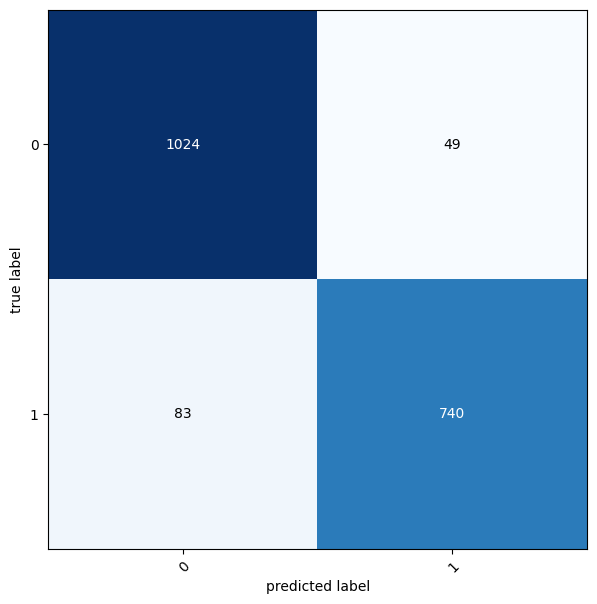

In [43]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#setup confusion instance and compare predictions to targets
confmat=ConfusionMatrix(num_classes=2, task="binary")

confmat_tensor=confmat(preds=y_test_pred, target=y_test )

#plot the confusion matrix
fig , ax= plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy() #his works with matplotlib which works with numpy so all tensors should first be converted to numpy
    ,class_names=[0, 1],
    figsize=(10,7)
)


range(0, 25)


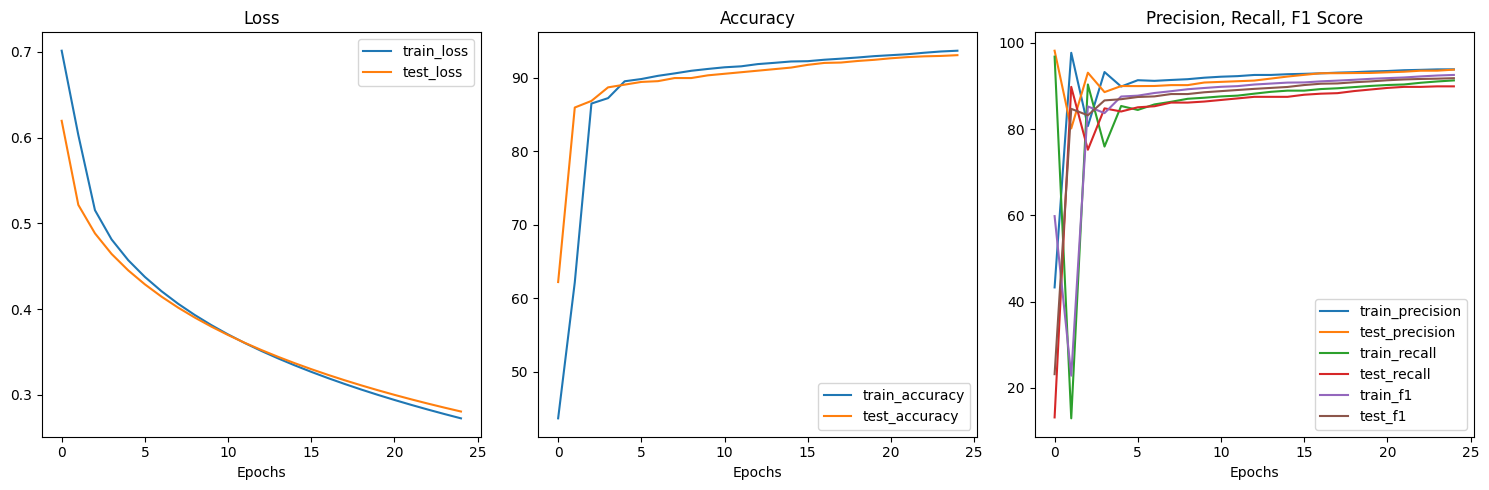

In [44]:
plot_loss_curves(model_0_results)


we notice that our model is generally performing very well on all important metrics (accuracy, precision, recall, f1 score) and our loss is very low and keeps getting lower the more time our model spends training. lets make some more predictions.

In [45]:
#make some predictions
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_0(X_test))).squeeze()

print(f"our model's predictions for the first 5 news labels in our dataset are {y_preds[:5]}")
print(f"5 first actual labels are {y_test[:5]}")

our model's predictions for the first 5 news labels in our dataset are tensor([1., 1., 1., 0., 1.])
5 first actual labels are tensor([1., 1., 1., 0., 1.])


## Introducing Non Linearity
"What patterns could we draw if given a number of infinite staight and non straight lines", or in machine learning terms a very large amount of linear and non linear functions. We will try to implement non-linearity to our model to see if we can get to perform even better

In [46]:
#Create the class of the model
class FakeNewsDetectionModelV1(nn.Module):
     def __init__(self):
        super().__init__()

        self.layer_1=nn.Linear(in_features=107136, out_features=10)
        self.layer_2=nn.Linear(in_features=10, out_features=10)
        self.layer_3=nn.Linear(in_features=10, out_features=1)
        self.relu=nn.ReLU() #relu is a non linear activation function

     def forward(self, x):
        #we put the non linear activation function between each layer
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1=FakeNewsDetectionModelV1().to(device)
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0023,  0.0025, -0.0007,  ..., -0.0021, -0.0011,  0.0017],
                      [ 0.0017,  0.0026, -0.0002,  ...,  0.0008,  0.0023,  0.0016],
                      [ 0.0003, -0.0005, -0.0007,  ..., -0.0018,  0.0015,  0.0020],
                      ...,
                      [ 0.0006, -0.0006,  0.0029,  ...,  0.0015, -0.0017,  0.0027],
                      [ 0.0025,  0.0026, -0.0006,  ..., -0.0030,  0.0018, -0.0029],
                      [ 0.0022, -0.0023,  0.0027,  ..., -0.0024, -0.0011,  0.0004]])),
             ('layer_1.bias',
              tensor([ 0.0019, -0.0003, -0.0030, -0.0011,  0.0008, -0.0007, -0.0029, -0.0019,
                      -0.0013, -0.0021])),
             ('layer_2.weight',
              tensor([[ 1.6993e-01,  1.9542e-01,  4.0499e-02, -1.4865e-01,  2.5267e-01,
                       -4.0328e-02, -3.0977e-01, -1.9135e-01, -4.9563e-03, -3.1073e-01],
                      [-2.1002e-01,  2.5932e-01,  1.4946e-

In [47]:
#view the first 5 predictions of the forward pass of our data in the new untrained model we created
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_1(X_test))).squeeze()

print(f"our model's predictions for the first 5 news labels in our dataset are {y_preds[:5]}")
print(f"5 first actual labels are {y_test[:5]}")

our model's predictions for the first 5 news labels in our dataset are tensor([0., 0., 0., 0., 0.])
5 first actual labels are tensor([1., 1., 1., 0., 1.])


In [48]:
#train this model as well and iew the results it produces
from sklearn.metrics import precision_score, recall_score, f1_score
from timeit import default_timer as timer
#set a manual seed to control the randomness
torch.manual_seed(42)

#set the epochs and device agnostic code
epochs=25

X_train,y_train= X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)
model_1_results={
    "train_loss": [],
    "train_acc": [],
    "train_precision": [],
    "train_recall": [],
    "train_f1": [],
    "test_loss": [],
    "test_acc": [],
    "test_precision": [],
    "test_recall": [],
    "test_f1": [],
  }
#make training and evaluation loop
start_time=timer()
for epoch in tqdm(range(epochs)):
    #set the mode to training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()


    #convert probabilities to predictions
    y_pred=torch.round(torch.sigmoid(y_logits))

    #calculate loss
    loss=loss_fn(y_logits #if loss_fn was BCELoss() prediction probabilitites should have been passed as input instead of logits
              , y_train)


    #calculate training accuracy
    acc=accuracy_fn(y_true=y_train, y_pred=y_pred)

    #optimizer zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimizer step
    optimizer.step()

    #set the mode to evaluation
    model_1.eval()

    #perform forward pass on testing data
    with torch.inference_mode():
        #forward pass
        y_test_logits = model_1(X_test).squeeze()

        #convert logits to probabilities
        y_test_probs=torch.sigmoid(y_test_logits)

        #convert probabilities to predictions
        y_test_pred=torch.round(y_test_probs)

        #calculate loss on testing predictions
        test_loss=loss_fn(y_test_logits, y_test)

        #calculate testing accuracy
        test_acc=accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 5 == 0 :
        print(f"epoch : {epoch}, training loss: {loss:.5f}, test loss: {test_loss:.5f}, training accuracy {acc}, testing accuracy {test_acc}")


    # Update result dictionary
    model_1_results["train_loss"].append(loss.item())
    model_1_results["train_acc"].append(acc)

    model_1_results["test_loss"].append(test_loss.item())
    model_1_results["test_acc"].append(test_acc)


end_time=timer()
print(f"total training time is {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

epoch : 0, training loss: 0.68751, test loss: 0.68755, training accuracy 56.67941447975735, testing accuracy 56.592827004219416
epoch : 5, training loss: 0.68751, test loss: 0.68755, training accuracy 56.67941447975735, testing accuracy 56.592827004219416
epoch : 10, training loss: 0.68751, test loss: 0.68755, training accuracy 56.67941447975735, testing accuracy 56.592827004219416
epoch : 15, training loss: 0.68751, test loss: 0.68755, training accuracy 56.67941447975735, testing accuracy 56.592827004219416
epoch : 20, training loss: 0.68751, test loss: 0.68755, training accuracy 56.67941447975735, testing accuracy 56.592827004219416
total training time is 71.363 seconds


In [49]:
model_1_results

{'train_loss': [0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283,
  0.6875070929527283],
 'train_acc': [56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  56.67941447975735,
  

range(0, 25)


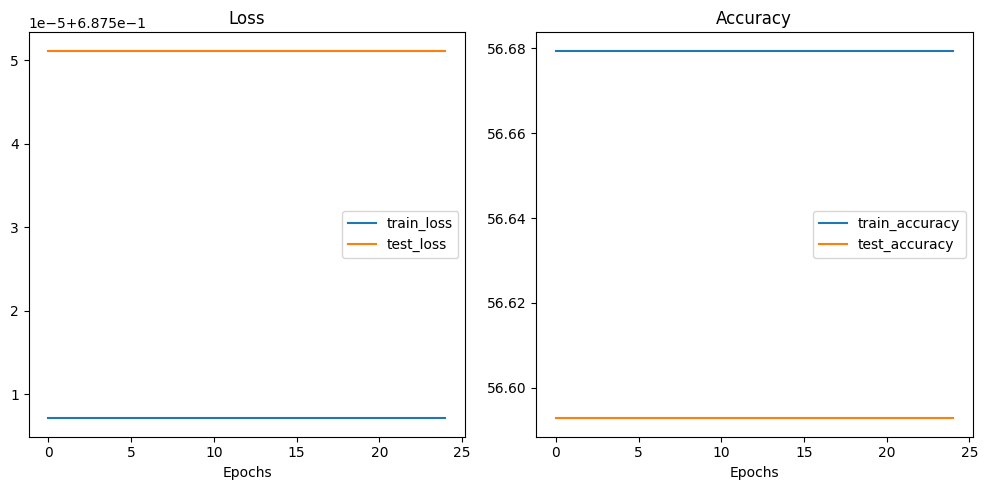

In [50]:
plot_loss_curves(model_1_results)

## Model Comparison
From the results we gather while training cothe `model_0` and `model_1` it is clear that non-linearity not only does not help our model's performance, but since its accuracy is staying steady at about 56% for each epoch and we are dealing with a binary classification, it performs only slightly better than random guessing. This is to be expected since our dataset is one-dimensional so a simple linear approach, where we utilize the linear regression formula works better in this case. Final step is to save the now trained `model_0` for later use.

In [51]:
#save the trained model
from pathlib import Path

#create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create a model save path
MODEL_NAME="fake_news_detection_modelV0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


#save the model state_dict
print(f"saving the model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

saving the model to : models/fake_news_detection_modelV0.pth


In [52]:
#Try loading the model
#in order to load a saved model's state_dict we need to instantiate a new instance of the class
loaded_model_0=FakeNewsDetectionModelV0()

#load the saved state_dict of the model (this will update the model's parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0024,  0.0262, -0.0008,  ..., -0.0021, -0.0012,  0.0017],
                      [ 0.0016, -0.0131, -0.0002,  ...,  0.0008,  0.0023,  0.0016],
                      [ 0.0001, -0.0394, -0.0006,  ..., -0.0018,  0.0015,  0.0021],
                      [ 0.0023, -0.0326, -0.0026,  ...,  0.0016, -0.0025,  0.0015],
                      [ 0.0018,  0.0479,  0.0019,  ...,  0.0022,  0.0026, -0.0002]])),
             ('layer_1.bias',
              tensor([-0.0165,  0.0068,  0.0226,  0.0188, -0.0257])),
             ('layer_2.weight',
              tensor([[-0.2851,  0.1897,  0.4669,  0.3931, -0.5747]])),
             ('layer_2.bias', tensor([0.1148]))])